![Alt Text](./fig/banner.png)

I recommend running Jupyter Lab in dark mode:

`Settings`-->`Theme`--> `JupyterLab Dark`

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

In [21]:
## Comment this out if you want the plots in light mode
plt.style.use('dark_background')

# DFT Refresher

Let's start with a brief refresher on the Discrete Fourier Transform with a simple, small example:

In [22]:
n_tones = 8
fs = 8e9 # Hz

The center frequency of each FFT bin is given by the following: 

In [23]:
fft_bin_centers = np.linspace(-fs / 2, fs / 2 - (fs/n_tones), n_tones)

In [24]:
print(f'Frequencies located at: {fft_bin_centers*1e-6} MHz')

Frequencies located at: [-4000. -3000. -2000. -1000.     0.  1000.  2000.  3000.] MHz


If we generate a timeseries with the correct sample rate, we can create sinusoidal waves at the bin center frequencies. In the next cell, `signals` is an array where each row is a timeseries for a single component waveform. I also FFT-shift the signals, effectivly permuting the order of the frequencies so the first row is the DC-component, the second row the first Fourier component, and so on:

In [25]:
time = np.arange(100)/fs
signals = np.fft.fftshift(np.exp(1j*(time*fft_bin_centers[:,None]+0)),axes=0)

Now we can plot the Fourier component waveforms (these are the waveforms with frequencies corresponding to the center of each FFT bin). I'm just plotting the first half because the second-half signals are the imaginary components at the same frequncies and they will just overlap with the first half.

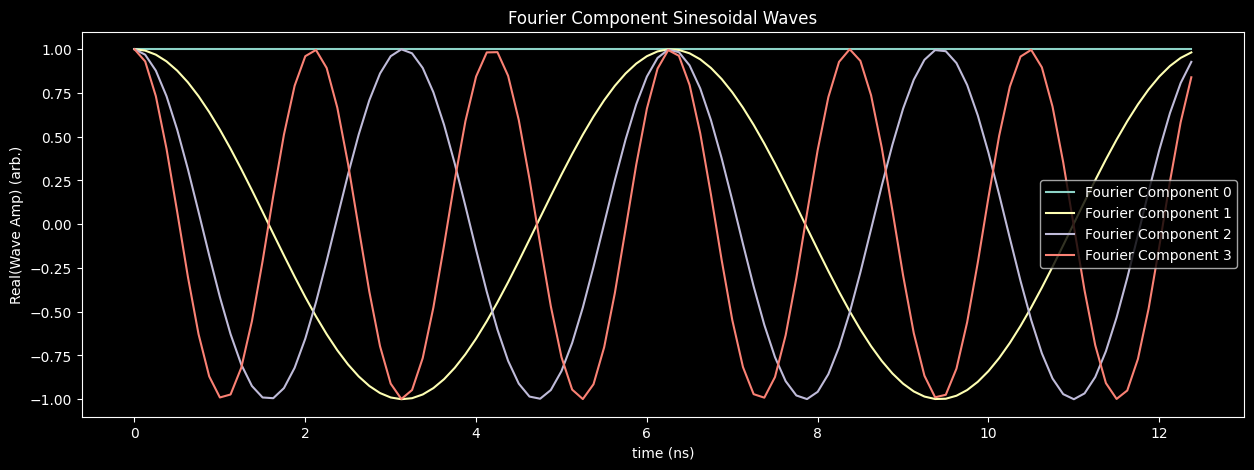

In [26]:
fig, ax = plt.subplots(figsize=(15,5))
for freq in range(n_tones//2):
    ax.plot(time*1e9, np.real(signals[freq,:]), label=f'Fourier Component {freq}')
ax.set_xlabel('time (ns)')
ax.set_ylabel('Real(Wave Amp) (arb.)')
ax.legend(loc='center right')
ax.set_title('Fourier Component Sinesoidal Waves');

# Full-Scale Example
## Using the Inverse Discrete Fourier Transform to Efficiently Change Fixed Tone Amplitudes

In our real experiment, there will be $2^{13}=8192$ tones, so we will start by specifying 8192 amplitudes. Each amplitude corresponds to one tone.

In [36]:
n_tones = 2**13
amps = np.zeros(n_tones)
amps[4296] = 1 # Set the amplitude of a tone
amps[5896] = 0.8 # Set the amplitude of a tone
amps = np.fft.fftshift(amps) # Re-order to something more intuitive

Standard Fourier order is DC bin first, then smallest positive frequency, increasing to largest positive frequency, then wrapping to largest negative frequency and counting up to the smallest positive frequency. This is a little confusing to *wrap* your head around so I will just apply an fft-shift to the amplitude vector which effectivly moves the DC-component to the middle of the vector. Now the order specified goes from largest negative frequency to largest positive frequency (like the number line). All possible frequencies (in the correct order) are given by:

In [48]:
possible_tones = np.fft.fftshift(np.fft.fftfreq(n_tones, 1 / fs))

In [38]:
## Note this is the same as
#tones_intuitive = np.linspace(-fs / 2, fs / 2 - (fs/n_tones), n_tones)
#(possible_tones == tones_intuitive).all()

Now we will construct a complex vector `fft` that is `n_tones`-long where each index specifies the frequency of that tone as defined by `possible_tones`. Think of this vector as the Fourier representation of the signal. I will also add in random phases. The multiply by `n_tones` is needed for normalization for the `numpy` [definition of the Inverse Discrete Fourier Transform](https://numpy.org/doc/2.2/reference/routines.fft.html#module-numpy.fft).

In [39]:
phases = np.random.default_rng(seed=2).uniform(-np.pi, np.pi, size=n_tones) # 2^13 random phases (use np.angle range)
print(f'generated random phases {phases[amps !=0]}')
fft = amps * np.exp(1.j*phases) * n_tones # Fourier signal

generated random phases [2.46007536 1.10269441]


Next step is to compute the time domain signal by taking the Inverse Fourier Transform

In [40]:
data = np.fft.ifft(fft)

We can look at the time domain signal we just calculated: 

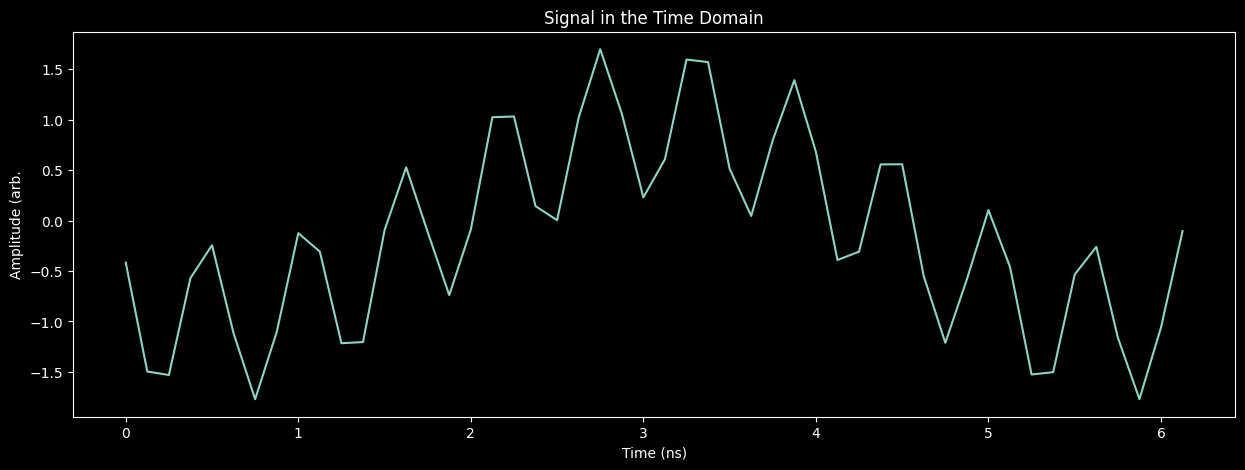

In [41]:
fig, ax = plt.subplots(figsize=(15,5))
plt_sl = slice(0,50)
ax.set_title('Signal in the Time Domain')
ax.plot(1e9*np.arange(n_tones)[plt_sl]/fs, np.real(data[plt_sl]))
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Amplitude (arb.');

### Analyze the Time Domain Signal

In [42]:
fft_calc = (np.abs(np.fft.fftshift(np.fft.fft(data)))) # Compute the FFT mag of the time domain signal
phase_calc = np.angle(np.fft.fftshift(np.fft.fft(data))) # Calculate phases using arctan (imag / real)

# Find the frequencies (peaks in the Fourier spectrum)
idxs = signal.find_peaks(fft_calc, height = 100)[0]
found_freqs = possilbe_tones[idxs]
found_amps = fft_calc[idxs] / n_tones
found_phases = phase_calc[idxs]

In [43]:
print(f'Found frequencies:{found_freqs} with amplitudes:{found_amps} and phases {found_phases}')

Found frequencies:[1.9531250e+08 1.7578125e+09] with amplitudes:[1.  0.8] and phases [2.46007536 1.10269441]


Next, we can reconstruct the Fourier representation to ensure we are correctly controlling the frequencies, phases, and amplitudes and otherwise correctly applying IFFT to efficiently modulate amplitudes of fixed frequencies.

## Plot the Fourier Spectrum of the Time Domain Signal we Computed using IFFT

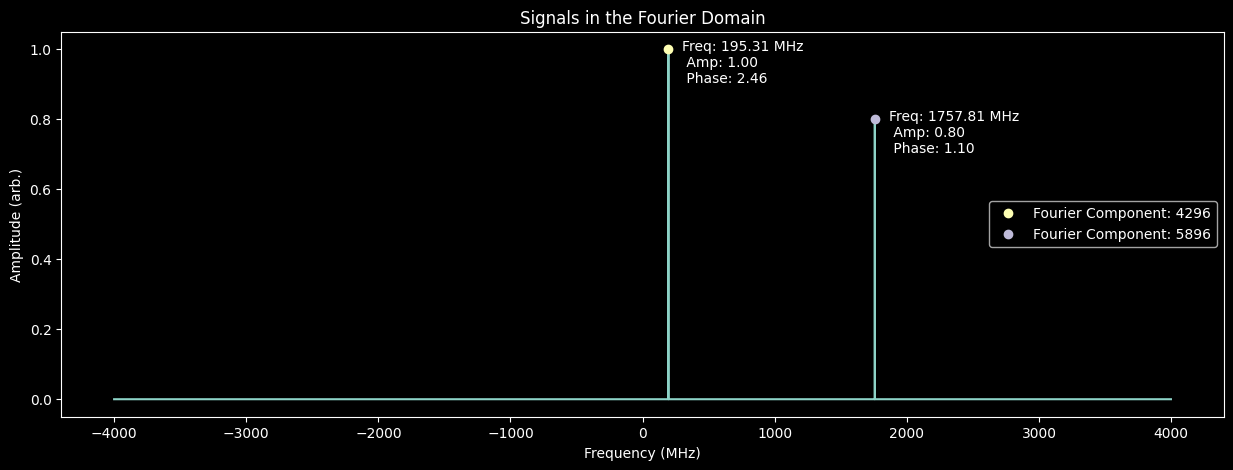

In [44]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title('Signals in the Fourier Domain')
ax.plot(possilbe_tones*1e-6, fft_calc / n_tones)
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Amplitude (arb.)')
for sig in range(found_freqs.size):
    ax.plot(found_freqs[sig]*1e-6, found_amps[sig], "o", label=f'Fourier Component: {idxs[sig]}')
    ax.annotate(f'Freq: {found_freqs[sig]*1e-6:.2f} MHz \n Amp: {found_amps[sig]:.2f} \n Phase: {found_phases[sig]:.2f}', xy=(found_freqs[sig]*1e-6, found_amps[sig]), xycoords='data',
                    xytext=(10, -24), textcoords='offset points')
ax.legend(loc='center right');

In the next cell, we will individually calculate and plot the Fourier components using the information we pulled out of the time domain signal and we will see it matches what we specified when we created the signal from the Fourier domain representaiton using IFFT. We will also sum these computed Fourier components to ensure it matches the time domain signal (`data`).

*\* Technical Note: When computing the Fourier component `f_comp`, `np.fft.fftfreq` gives frequencies in Hz (cycles per second), but the complex exponential expects radians: e^{j(2π f t + φ)} so we need to multiply the computed frequency `found_freqs` by 2π. Also divide by `n_tones` is needed for proper amplitude normalization with numpy fft [default settings](https://numpy.org/doc/2.2/reference/routines.fft.html#module-numpy.fft)*.

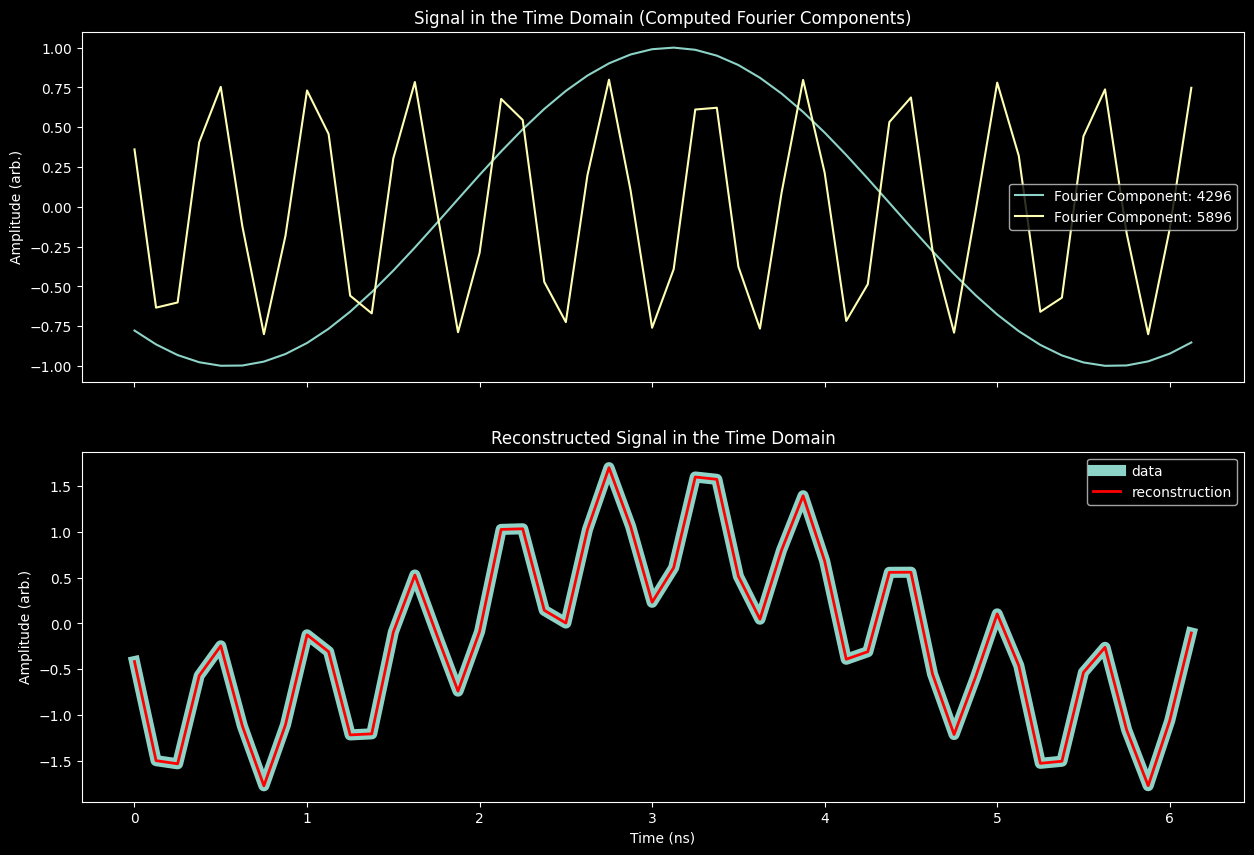

In [47]:
fig, ax = plt.subplots(2,1,figsize=(15,10), sharex=True)
plt_sl = slice(0,50)
t = np.arange(n_tones)/fs
ax[0].set_title('Signal in the Time Domain (Computed Fourier Components)')
ax[0].set_ylabel('Amplitude (arb.)')
composite_calc = np.zeros(n_tones, dtype=np.complex128)
for sig in range(found_freqs.size):
    f_comp = n_tones * found_amps[sig] * np.exp(1j*(t*2*np.pi*found_freqs[sig]+found_phases[sig])) / n_tones # compute Fourier components from analyzed amp, freq, & phase
    ax[0].plot(1e9*t[plt_sl], np.real(f_comp[plt_sl]), label=f'Fourier Component: {idxs[sig]}')
    composite_calc+=f_comp # sum calculated Fourier components
ax[0].legend(loc='center right')
ax[1].set_title('Reconstructed Signal in the Time Domain')
ax[1].set_xlabel('Time (ns)')
ax[1].set_ylabel('Amplitude (arb.)')
ax[1].plot(1e9*t[plt_sl], np.real(data[plt_sl]), linewidth=8, color='C0', label='data')
ax[1].plot(1e9*t[plt_sl], np.real(composite_calc[plt_sl]), linewidth=2, color='r', label='reconstruction')
ax[1].legend(loc='upper right');